# `Project Overview`

**Dataset Name:**
FER-2013 (Facial Expression Recognition 2013)

**Source:**
Available on Kaggle under *“Emotion Detection from Faces”* or *“FER-2013”* dataset.

**Description:**

* The dataset consists of **grayscale facial images**, each sized **48×48 pixels**.
* Each image contains a **single face**, labeled with one of several basic human emotions.
* It is widely used for training and testing deep learning models for **facial emotion recognition**.

**Emotion Classes (7 total):**

1. Angry
2. Disgust
3. Fear
4. Happy
5. Sad
6. Surprise
7. Neutral

# `Importing the Data`

In [1]:
# Dataset Stored in the Github
!git clone https://github.com/Sainath-10/Emotion_Detection_from_Faces_Project.git

Cloning into 'Emotion_Detection_from_Faces_Project'...
remote: Enumerating objects: 8, done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 8 (from 2)
Receiving objects: 100% (8/8), 44.64 MiB | 14.53 MiB/s, done.


In [2]:
import zipfile

zip_ref = zipfile.ZipFile("/content/Emotion_Detection_from_Faces_Project/Emotion Detection from Faces Dataset.zip", "r")
zip_ref.extractall("Data")
zip_ref.close()

print("Dataset extracted successfully!")

Dataset extracted successfully!


# `Importing Libraries`

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.utils.class_weight import compute_class_weight


import warnings
warnings.filterwarnings("ignore")

# `Exploring the Data`

In [4]:
import os
import pandas as pd

base_path = "Data"

data = []

for folder in ["train", "test"]:
    folder_path = base_path + "/" + folder
    for emotion in os.listdir(folder_path):
        emotion_path = folder_path + "/" + emotion
        count = len(os.listdir(emotion_path))
        data.append({"Set": folder, "Emotion": emotion, "Image Count": count})

df = pd.DataFrame(data)
df

,Set,Emotion,Image Count
0,train,neutral,4965
1,train,surprise,3171
2,train,angry,3995
3,train,disgust,436
4,train,sad,4830
5,train,fear,4097
6,train,happy,7215
7,test,neutral,1233
8,test,surprise,831
9,test,angry,958


In [5]:
IMG_HEIGHT = 48
IMG_WIDTH = 48
IMG_CHANNELS = 3
BATCH_SIZE = 32
NUM_CLASSES = 7

In [6]:
# Preparing the Data

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_data = train_datagen.flow_from_directory(
    directory = "Data/train",
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
)

Found 28709 images belonging to 7 classes.


In [7]:
val_datagen = ImageDataGenerator(
    rescale = 1/255.
)

val_data = val_datagen.flow_from_directory(
    directory = "Data/test",
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    shuffle = False
)

Found 7178 images belonging to 7 classes.


In [8]:
train_data.image_shape

(48, 48, 3)

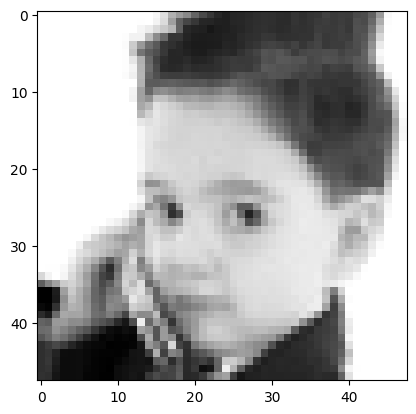

In [9]:
batch_1 = next(train_data)

plt.imshow(batch_1[0][0])

# `Handling the Imbalenced Data`

In [10]:
# Here we can see that the Data is Very Imbalenced

# There are 7215 ~ Happy  ,But only 436 for Disguist
df

,Set,Emotion,Image Count
0,train,neutral,4965
1,train,surprise,3171
2,train,angry,3995
3,train,disgust,436
4,train,sad,4830
5,train,fear,4097
6,train,happy,7215
7,test,neutral,1233
8,test,surprise,831
9,test,angry,958


In [11]:
class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_data.classes),
    y = train_data.classes
)
class_weights

array([1.02660468, 9.40661861, 1.00104606, 0.56843877, 0.82603942,
       0.84912748, 1.29337298])

In [12]:
class_weights = dict(enumerate(class_weights))
class_weights

{0: np.float64(1.0266046844269623),
 1: np.float64(9.406618610747051),
 2: np.float64(1.0010460615781582),
 3: np.float64(0.5684387684387684),
 4: np.float64(0.8260394187886635),
 5: np.float64(0.8491274770777877),
 6: np.float64(1.293372978330405)}

In [13]:
class_labels = train_data.class_indices.keys()
class_labels

print("Class Weights:")
for label, weight in zip(class_labels, class_weights.values()):
    print(f"{label}: {weight:.2f}")

Class Weights:
angry: 1.03
disgust: 9.41
fear: 1.00
happy: 0.57
neutral: 0.83
sad: 0.85
surprise: 1.29


# `Training a Model`

In [14]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(units=75, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),

    Dense(25, activation="relu"),
    BatchNormalization(),
    Dropout(0.2),

    Dense(7, activation="softmax")
])

In [22]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)

In [23]:
# Callbacks
early_stopper = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5,
                              restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.5,
                              patience = 3,
                              verbose = 1)


In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 75)             │       153,675 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 75)             │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 25)             │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           182 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,301 (977.74 KB)

 Trainable params: 249,653 (975.21 KB)

 Non-trainable params: 648 (2.53 KB)

In [25]:
epochs = 20

In [26]:
model_history = model.fit(x = train_data,
                          epochs = epochs,
                          validation_data = val_data,
                          callbacks = [early_stopper, reduce_lr],
                          class_weight = class_weights,
                          verbose = 1
                         )

Epoch 1/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 62s 58ms/step - accuracy: 0.1675 - loss: 2.1738 - val_accuracy: 0.2111 - val_loss: 1.8827 - learning_rate: 0.0010
Epoch 2/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.1903 - loss: 1.9300 - val_accuracy: 0.2194 - val_loss: 1.8534 - learning_rate: 0.0010
Epoch 3/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 48s 53ms/step - accuracy: 0.2162 - loss: 1.9039 - val_accuracy: 0.3016 - val_loss: 1.7774 - learning_rate: 0.0010
Epoch 4/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 47s 53ms/step - accuracy: 0.2667 - loss: 1.8136 - val_accuracy: 0.3858 - val_loss: 1.6430 - learning_rate: 0.0010
Epoch 5/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.3094 - loss: 1.7560 - val_accuracy: 0.2705 - val_loss: 1.9855 - learning_rate: 0.0010
Epoch 6/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - accuracy: 0.3175 - loss: 1.7208 - val_accuracy: 0.3945 - val_loss: 1.5788 - learning_rate: 0.0010
Epoch 7/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.3497 - l

we are Gettinng a **Accuracy of 0.4469** For **20** Epochs  which is not good

# `Using Transfer Learning`

In [15]:
MobileNetV2_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
)

MobileNetV2_model.trainable = True

for layer in MobileNetV2_model.layers[:-30]:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [16]:
inputs = Input(shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

x = MobileNetV2_model(inputs, training = False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation = "softmax")(x)

MobileNetV2_tl_model = Model(inputs = inputs, outputs = outputs)

In [17]:
MobileNetV2_tl_model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
# Callbacks
early_stopper = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5,
                              restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.5,
                              patience = 3,
                              verbose = 1)


In [19]:
MobileNetV2_tl_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,423 (8.93 MB)

 Trainable params: 1,608,839 (6.14 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [21]:
EPOCHS = 30

In [22]:
MobileNetV2_tl_model_history = MobileNetV2_tl_model.fit(
    x = train_data,
    epochs = EPOCHS,
    validation_data = val_data,
    callbacks = [early_stopper, reduce_lr],
    class_weight = class_weights,
    verbose = 1
)

Epoch 1/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 97s 81ms/step - accuracy: 0.1994 - loss: 2.0204 - val_accuracy: 0.2974 - val_loss: 2.0664 - learning_rate: 0.0010
Epoch 2/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 45s 50ms/step - accuracy: 0.2374 - loss: 1.8082 - val_accuracy: 0.2644 - val_loss: 2.0484 - learning_rate: 0.0010
Epoch 3/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 47s 52ms/step - accuracy: 0.2677 - loss: 1.7710 - val_accuracy: 0.2846 - val_loss: 1.7820 - learning_rate: 0.0010
Epoch 4/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 47s 52ms/step - accuracy: 0.2881 - loss: 1.7365 - val_accuracy: 0.3614 - val_loss: 1.7150 - learning_rate: 0.0010
Epoch 5/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 47s 53ms/step - accuracy: 0.3107 - loss: 1.7080 - val_accuracy: 0.2994 - val_loss: 1.7820 - learning_rate: 0.0010
Epoch 6/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.3216 - loss: 1.6806 - val_accuracy: 0.3743 - val_loss: 1.6637 - learning_rate: 0.0010
Epoch 7/30
898/898 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.3325 - l